In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Création de la classe Dataset

In [46]:
### Parameters ###
fft_size = 512 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 10 # threshold for spectrograms (lower filters out more noise)

class CustomDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean_spec = signal.stft(self.clean[index, :], nperseg=254, noverlap=120)[2].reshape((1, 128, 32))
        noisy_spec = signal.stft(self.noisy[index, :], nperseg=254, noverlap=120)[2].reshape((1, 128, 32))

        clean_tensor = torch.from_numpy(normalisation(clean_spec)).to(torch.float32)
        noisy_tensor = torch.from_numpy(normalisation(noisy_spec)).to(torch.float32)
        return clean_tensor, noisy_tensor

# Configuration des paramètres du CNN

In [47]:
class config:
    batch_size=1
    learning_rate=1e-3
    epochs=20

# Création du dataset

In [48]:
clean = pd.read_csv('label.csv').to_numpy()
noisy = pd.read_csv('train.csv').to_numpy()

test_clean = clean[:10]
test_noisy = noisy[:10]

training_dataset = CustomDataset(clean[10:900], noisy[10:900])
validation_dataset = CustomDataset(clean[900:], noisy[900:])

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)

# Affichage d'un spectrogramme

(128, 32)


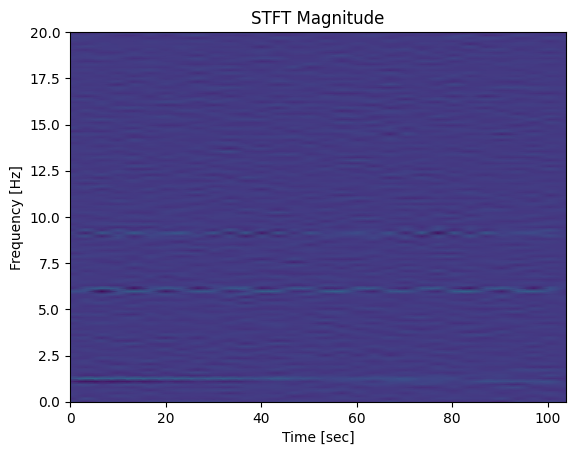

(800.0, 900.0)

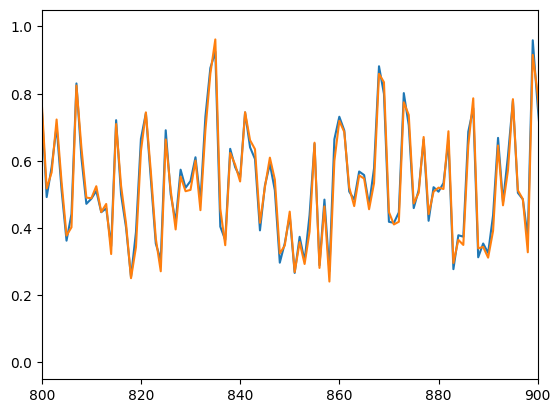

In [49]:
s = test_noisy[6, :]

def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)


f, t, Zxx = signal.stft(s, 40, nperseg=254, noverlap=120)
amp = 2 * np.sqrt(2)

Zxx = normalisation(Zxx)

print(Zxx.shape)

t2, x = signal.istft(Zxx, 40, nperseg=254, noverlap=120)

plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.figure()
plt.plot(np.arange(0, 4096, 1), normalisation(x[:4096]))
plt.plot(np.arange(0, 4096, 1), normalisation(s))
plt.xlim([800, 900])


# Création du modèle

In [50]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

# Résumé du Modèle

In [51]:
model = autoencoders().to(device)

summary(model, (1, 128, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 32]             832
              ReLU-2          [-1, 32, 128, 32]               0
         MaxPool2d-3           [-1, 32, 64, 16]               0
            Conv2d-4           [-1, 64, 64, 16]          51,264
              ReLU-5           [-1, 64, 64, 16]               0
         MaxPool2d-6            [-1, 64, 32, 8]               0
            Conv2d-7           [-1, 128, 32, 8]         204,928
              ReLU-8           [-1, 128, 32, 8]               0
         MaxPool2d-9           [-1, 128, 16, 4]               0
  ConvTranspose2d-10           [-1, 128, 32, 8]         409,728
             ReLU-11           [-1, 128, 32, 8]               0
  ConvTranspose2d-12           [-1, 64, 64, 16]         204,864
             ReLU-13           [-1, 64, 64, 16]               0
  ConvTranspose2d-14          [-1, 32, 

# Fonctions d'entrainement et de validation

In [74]:
def trainA(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):
        total_loss = 0.0

        clean = clean.to(device)
        noisy = noisy.to(device)

        optimizer.zero_grad()
        pred = model(noisy)

        t1, pred1D = signal.istft(pred.cpu().detach().numpy().reshape(128, 32), 40, nperseg=254, noverlap=120)
        t2, clean1D = signal.istft(clean.cpu().detach().numpy().reshape(128, 32), 40, nperseg=254, noverlap=120)

        t1, t2, pred1D, clean1D = t1[:4096], t2[:4096], normalisation(pred1D[:4096]), normalisation(clean1D[:4096])

        if i%500 == 0:
            plt.figure()
            plt.plot(np.arange(0, 4096, 1), pred1D)
            plt.plot(np.arange(0, 4096, 1), clean1D)
            plt.xlim([0, 500])
            plt.show()

        pred1D = torch.from_numpy(pred1D.reshape(1, 4096)).to(torch.float32).to(device)
        clean1D = torch.from_numpy(clean1D.reshape(1, 4096)).to(torch.float32).to(device)

        curr_loss = loss_fn(pred1D, clean1D)

        curr_loss.requires_grad = True

        curr_loss.backward()
        optimizer.step()

        total_loss += curr_loss

    print('[Epoch number : %d] loss: %.3f' %
          (epoch + 1, total_loss / 200))

def valA(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)

            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss
            if i % 100 == 0:
                print('[Valid Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, total_loss / 200))
                total_loss = 0.0

# Entrainement du CNN

  0%|          | 0/890 [00:00<?, ?it/s]

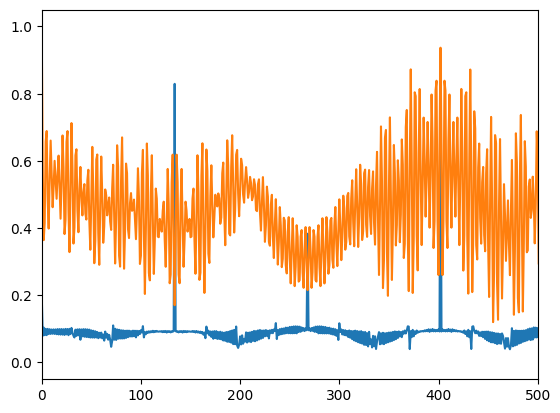

 55%|█████▌    | 490/890 [00:01<00:01, 290.14it/s]

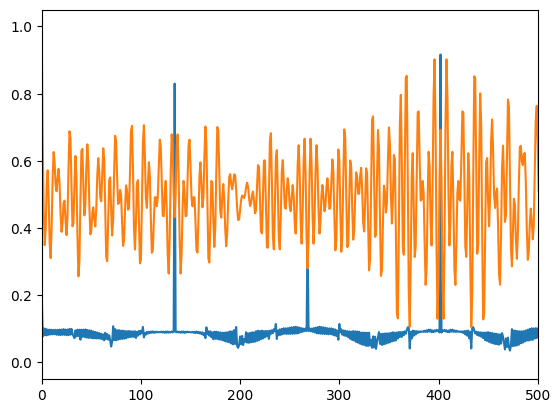

100%|██████████| 890/890 [00:03<00:00, 259.86it/s]


[Epoch number : 1] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

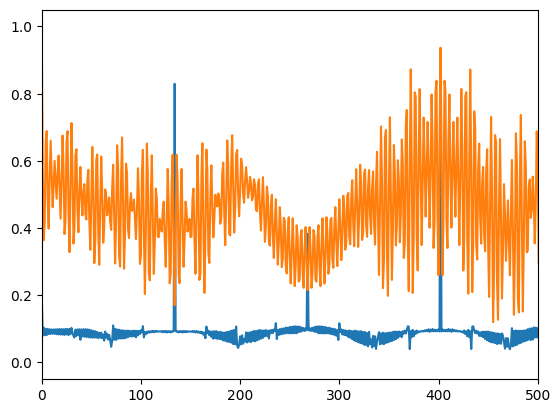

 55%|█████▌    | 490/890 [00:01<00:01, 286.86it/s]

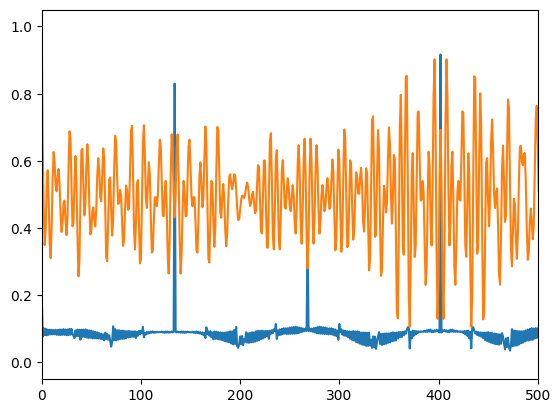

100%|██████████| 890/890 [00:03<00:00, 271.97it/s]


[Epoch number : 2] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

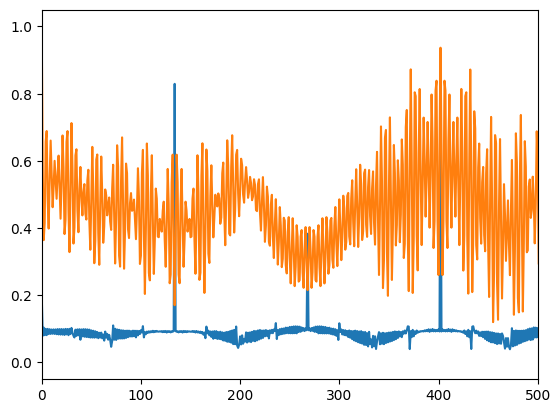

 54%|█████▍    | 481/890 [00:01<00:01, 275.70it/s]

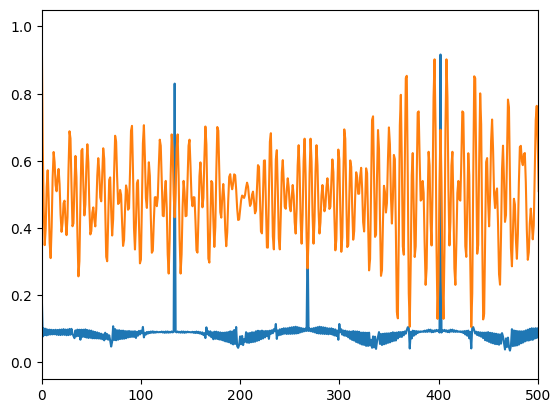

100%|██████████| 890/890 [00:03<00:00, 275.06it/s]


[Epoch number : 3] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

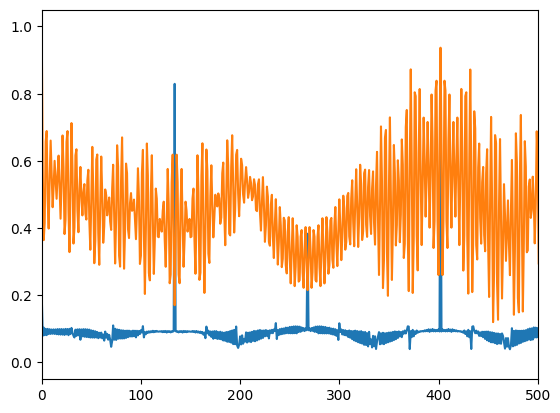

 56%|█████▌    | 497/890 [00:01<00:01, 324.72it/s]

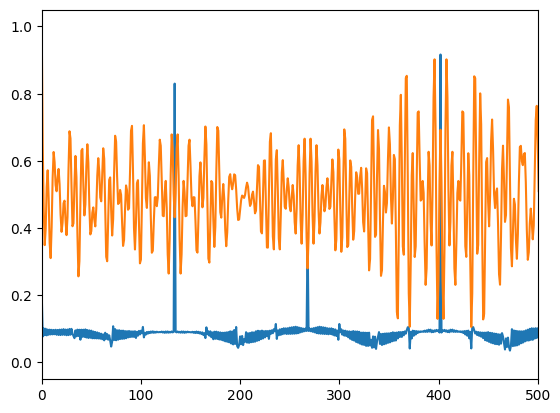

100%|██████████| 890/890 [00:02<00:00, 304.96it/s]


[Epoch number : 4] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

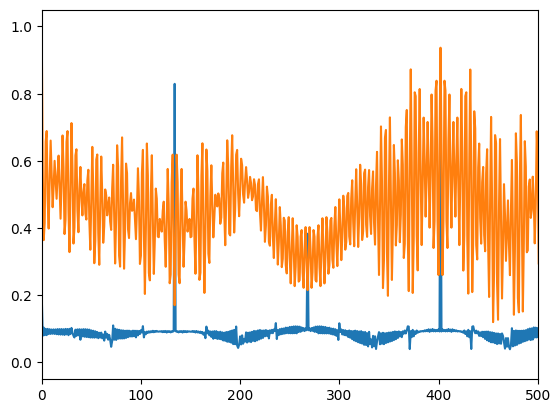

 55%|█████▍    | 486/890 [00:01<00:01, 329.30it/s]

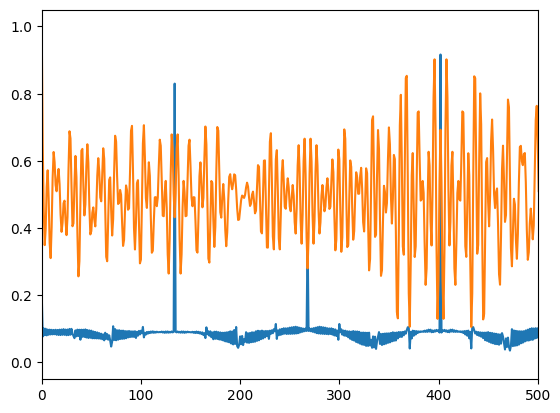

100%|██████████| 890/890 [00:02<00:00, 304.12it/s]


[Epoch number : 5] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

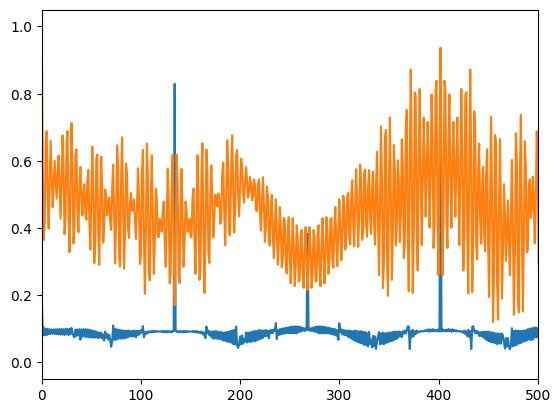

 53%|█████▎    | 475/890 [00:01<00:01, 328.25it/s]

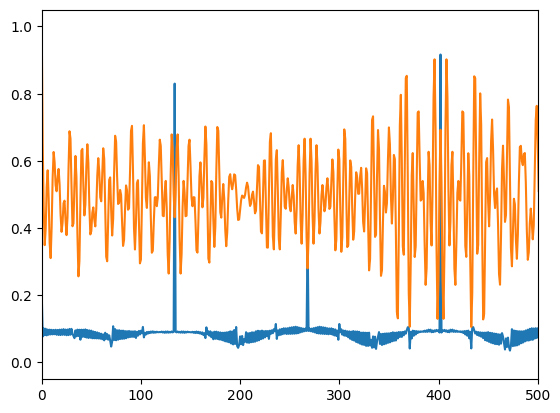

100%|██████████| 890/890 [00:03<00:00, 295.80it/s]


[Epoch number : 6] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

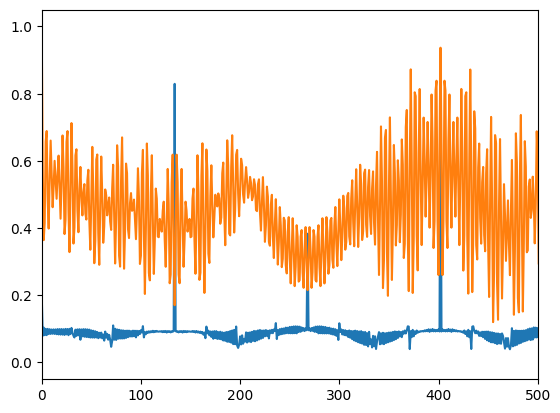

 53%|█████▎    | 468/890 [00:01<00:01, 326.05it/s]

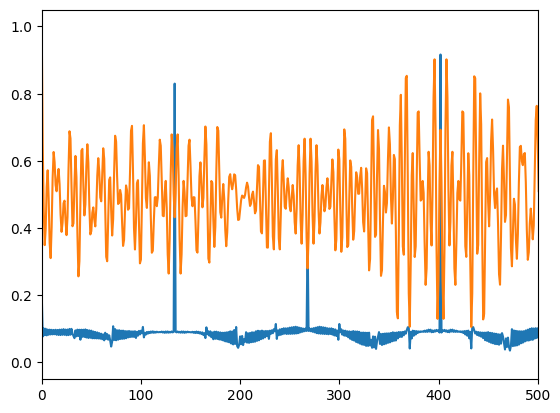

100%|██████████| 890/890 [00:02<00:00, 306.56it/s]


[Epoch number : 7] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

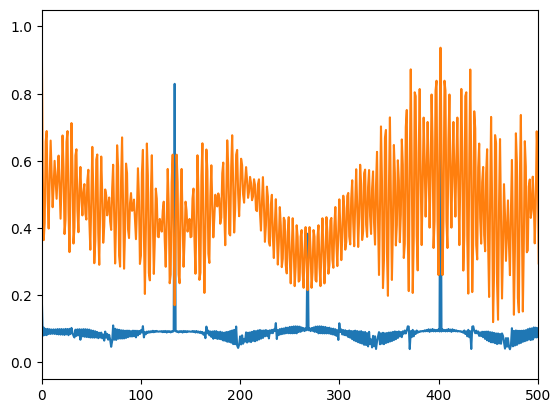

 53%|█████▎    | 476/890 [00:01<00:01, 327.33it/s]

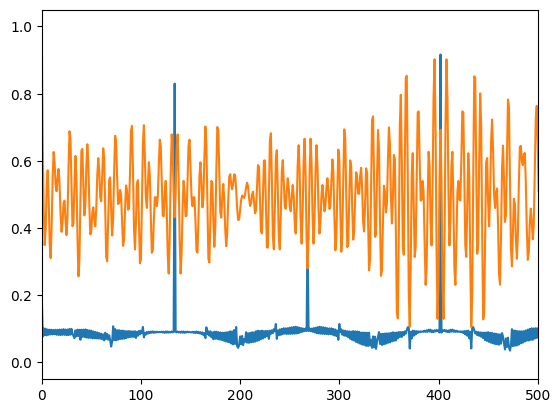

100%|██████████| 890/890 [00:02<00:00, 304.92it/s]


[Epoch number : 8] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

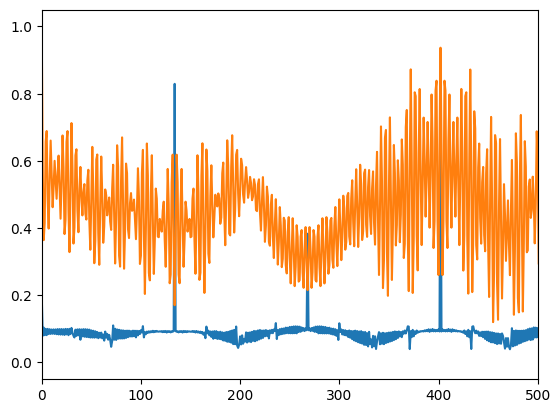

 55%|█████▌    | 491/890 [00:01<00:01, 311.07it/s]

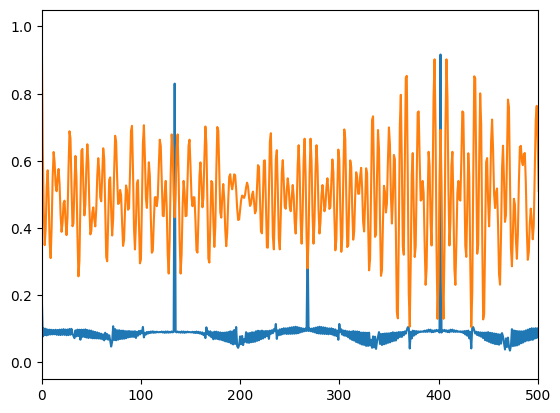

100%|██████████| 890/890 [00:03<00:00, 285.86it/s]


[Epoch number : 9] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

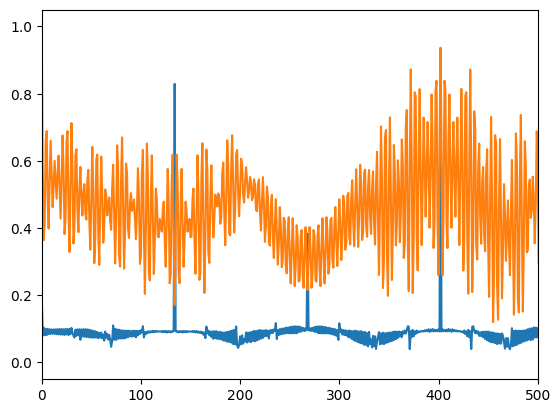

 55%|█████▌    | 493/890 [00:01<00:01, 309.30it/s]

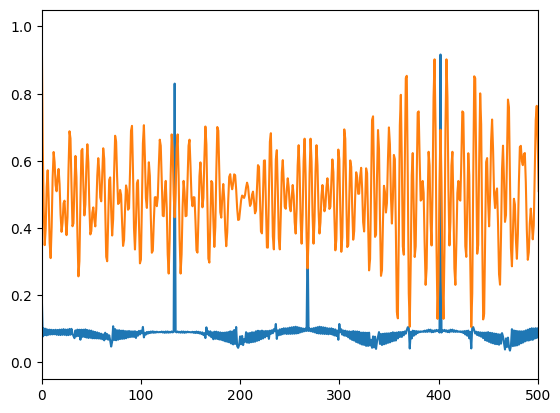

100%|██████████| 890/890 [00:02<00:00, 298.99it/s]


[Epoch number : 10] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

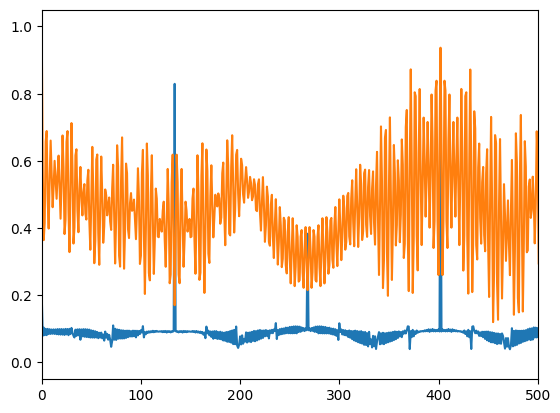

 54%|█████▍    | 479/890 [00:01<00:01, 329.75it/s]

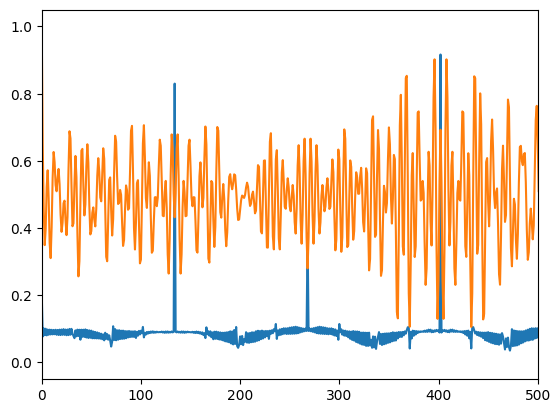

100%|██████████| 890/890 [00:02<00:00, 304.68it/s]


[Epoch number : 11] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

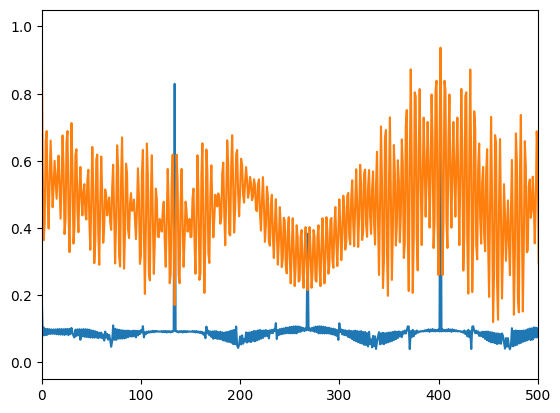

 54%|█████▍    | 481/890 [00:01<00:01, 285.92it/s]

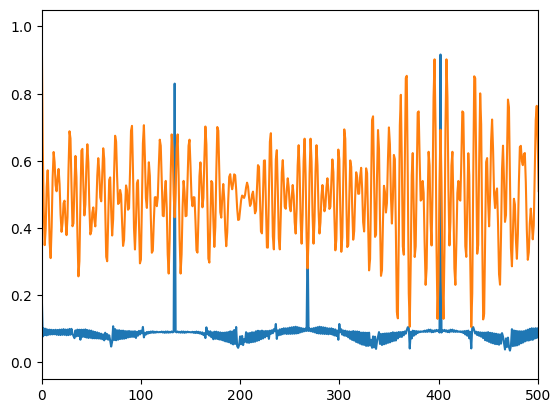

100%|██████████| 890/890 [00:03<00:00, 286.95it/s]


[Epoch number : 12] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

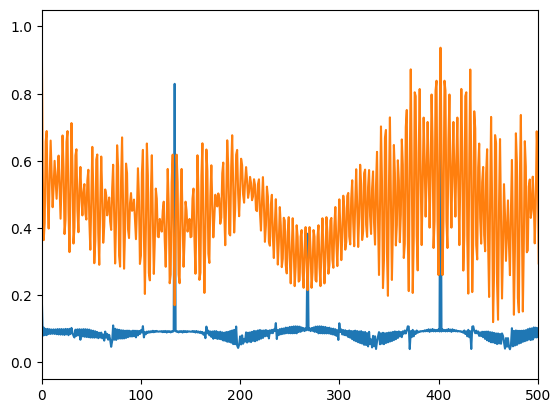

 56%|█████▌    | 497/890 [00:01<00:01, 304.84it/s]

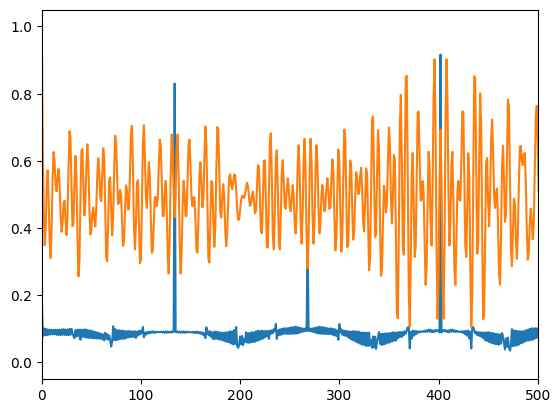

100%|██████████| 890/890 [00:02<00:00, 301.67it/s]


[Epoch number : 13] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

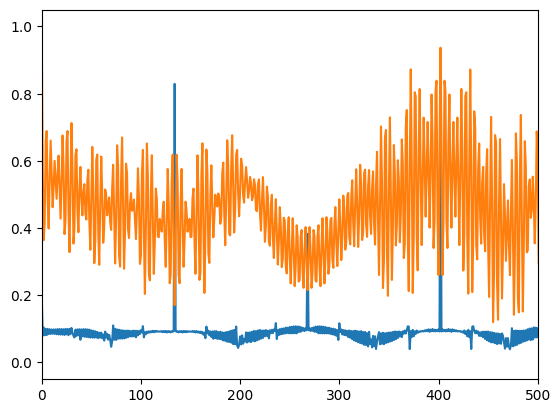

 53%|█████▎    | 473/890 [00:01<00:01, 333.32it/s]

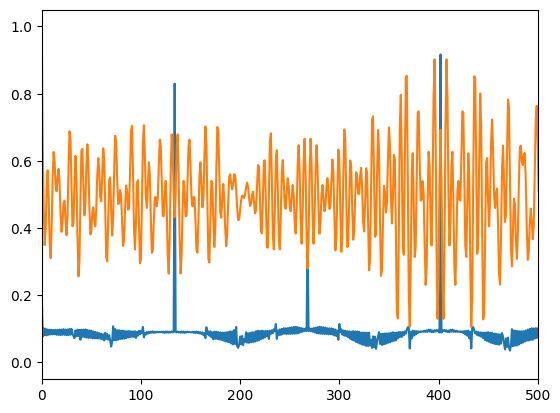

100%|██████████| 890/890 [00:02<00:00, 309.31it/s]


[Epoch number : 14] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

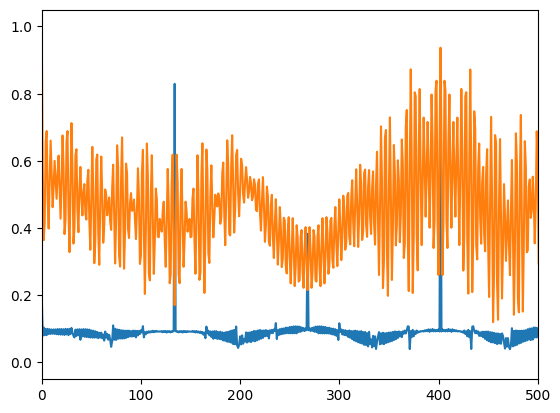

 53%|█████▎    | 468/890 [00:01<00:01, 303.76it/s]

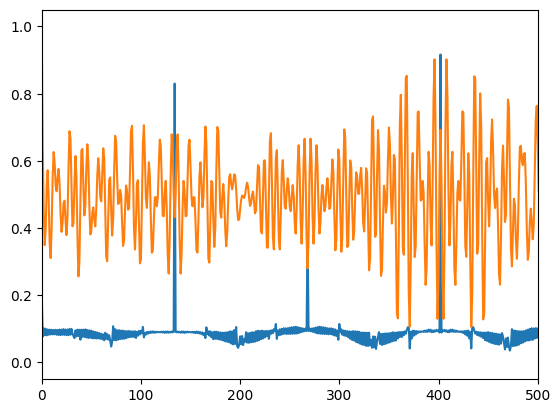

100%|██████████| 890/890 [00:03<00:00, 295.21it/s]


[Epoch number : 15] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

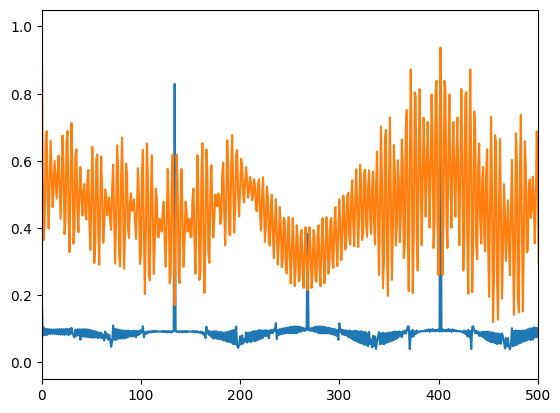

 53%|█████▎    | 473/890 [00:01<00:01, 332.12it/s]

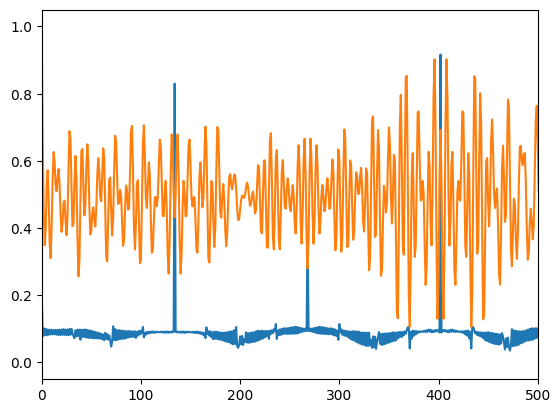

100%|██████████| 890/890 [00:02<00:00, 303.17it/s]


[Epoch number : 16] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

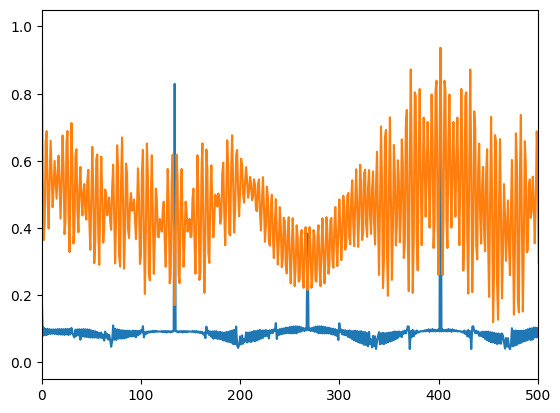

 54%|█████▎    | 478/890 [00:01<00:01, 324.51it/s]

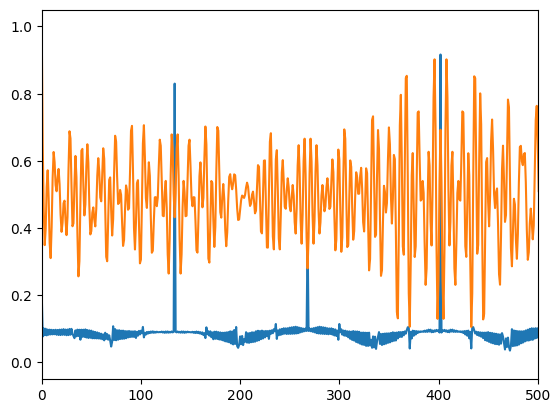

100%|██████████| 890/890 [00:02<00:00, 301.08it/s]


[Epoch number : 17] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

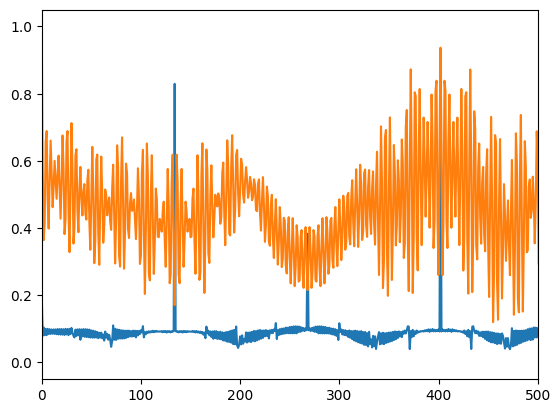

 53%|█████▎    | 473/890 [00:01<00:01, 292.26it/s]

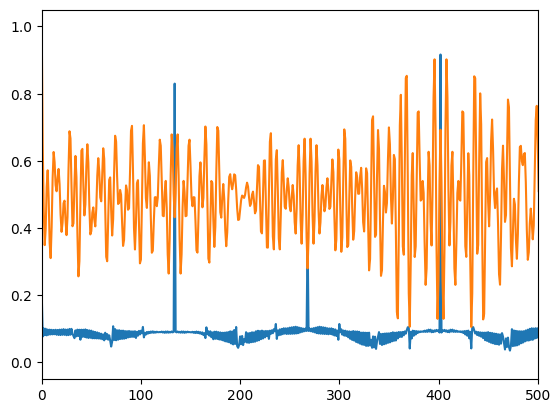

100%|██████████| 890/890 [00:03<00:00, 296.63it/s]


[Epoch number : 18] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

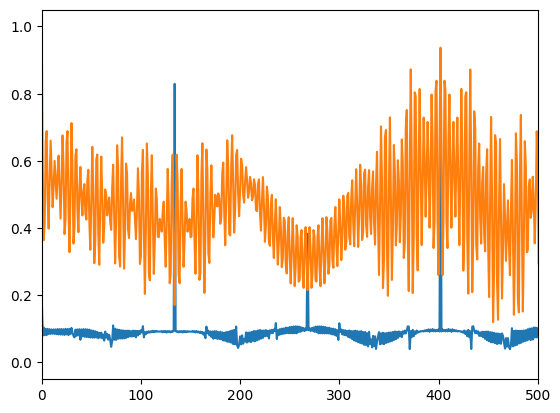

 53%|█████▎    | 476/890 [00:01<00:01, 298.02it/s]

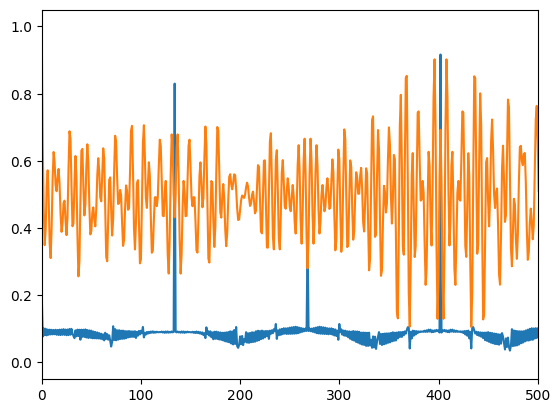

100%|██████████| 890/890 [00:03<00:00, 288.75it/s]


[Epoch number : 19] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

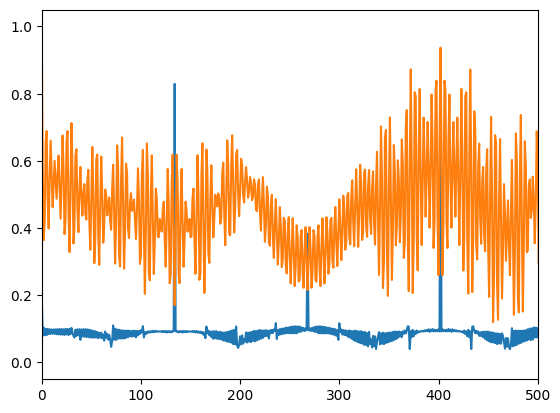

 53%|█████▎    | 474/890 [00:01<00:01, 303.71it/s]

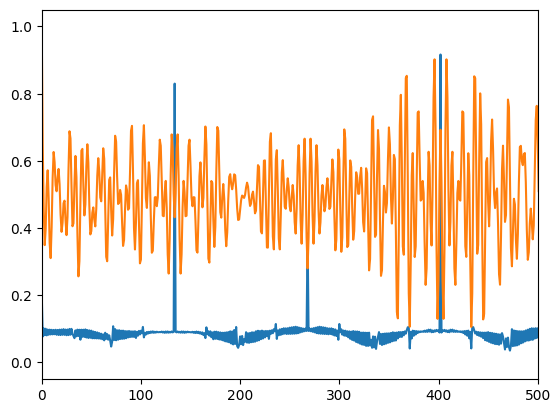

100%|██████████| 890/890 [00:03<00:00, 290.21it/s]

[Epoch number : 20] loss: 0.001


In [75]:
model = autoencoders().to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss

for epoch in range(config.epochs):
    trainA(trainloader, model, epoch, loss_fn, optimizer, device)
    # valA(validloader, model, epoch, loss_fn, device)

# Vérification

Text(0.5, 1.0, 'Original Spectrogram')

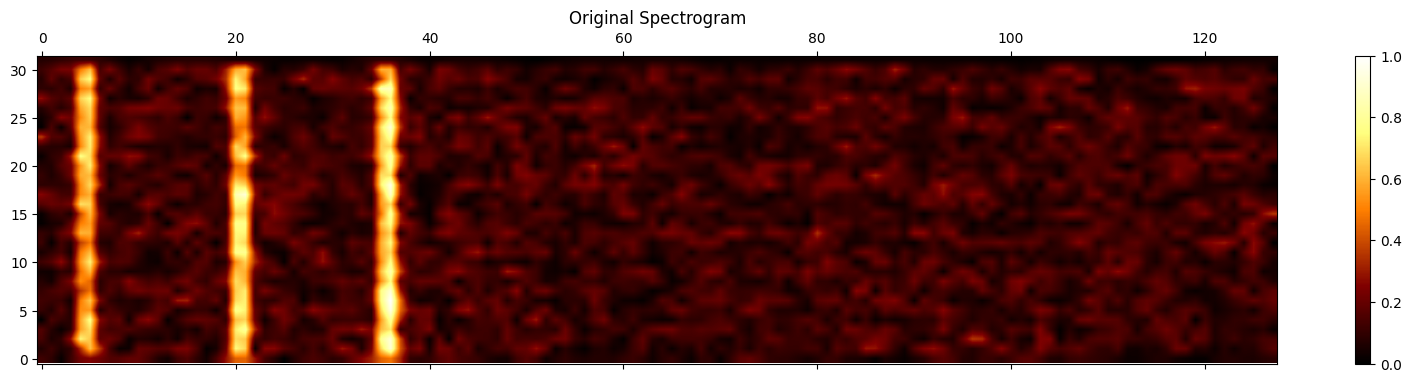

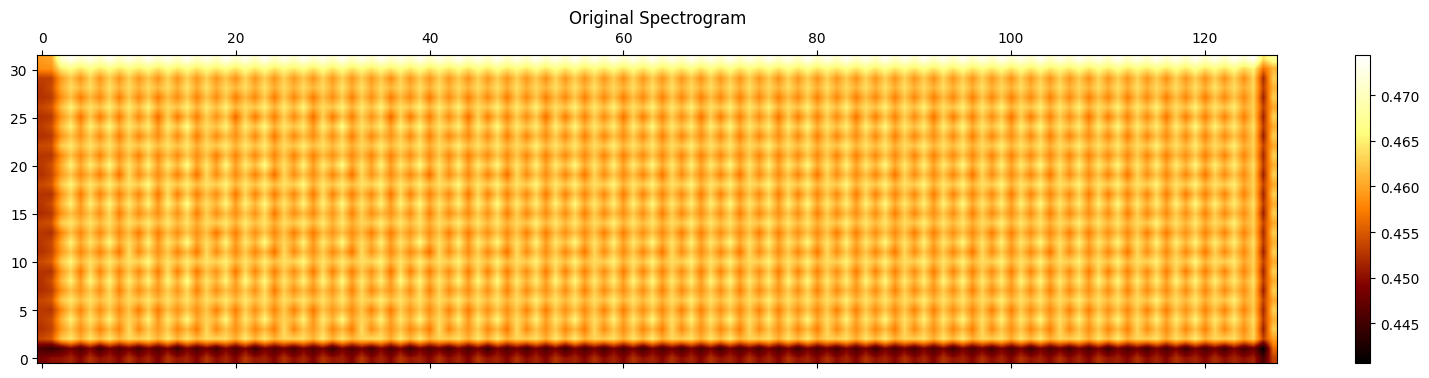

In [30]:
s = test_noisy[0, :]

X = normalisation(np.abs(signal.stft(s, nperseg=254, noverlap=120)[2]).reshape((1, 128, 32)))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

res = model.forward(torch.from_numpy(X).to(torch.float32).to(device))

Xres = res.cpu().detach().numpy().reshape(128, 32)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(Xres), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')
